# Titanic Survival Prediction Project
This project uses the famous Titanic dataset from the Kaggle competition platform. It is used to introduce people to both machine learning and how to participate in Kaggle data science competitions. The project *goal* is to predict who will survive the sinking of the Titanic. This project used a RandomForrest classifier to predict if someone will survive. It first starts with the basic tutorial provide from Kaggle and then expands it to use GridSearchCV to automate the disover of optimal hyperpameters as well as feature forward selection to improve accuracy. The project submits the predictions to the the Kaggle competition plaform where the predictions are scored, evaluatesd, and you are ranked against thousands of other competitors.

In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# The Data Source and Desription
The data source can be found at https://www.kaggle.com/competitions/titanic/data. The columns and first 5 rows are shown people. Most of the columns are self explantatory, though a couple of are a bit difficult to understnad. __Embarked__ described where the passensger boarded the Titatic. The cabin is where the passenger was accomodated on the ship.

In [15]:
train_data = pd.read_csv("data/titanic/train.csv")
train_data.head()

test_data = pd.read_csv("data/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Looking that the the distrubtion of women that survived as well as the distribution of men that survied, it clearly indicated that women had a higher change of surving.

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


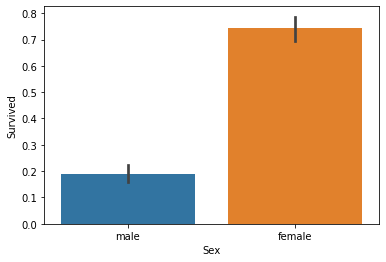

In [16]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)
sns.barplot(x='Sex',y='Survived',data=train_data)

The following is the basic modeling code from the tutorial. The training accuracy score is 0.7913. When the predicutions were evaluated and sent to Kaggle, it had a 0.7751 accuracy score. This score puts the competitor in the topic 56%.

In [17]:
from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
scores = cross_val_score(estimator=model,X=X,y=y,cv=10)
print(scores.mean())


0.7913060379071615


Before doing an more exploratory analysis or using more features, GridSearchCV was used to see if tuning the hyperparameters might quickly yield a better accuracy. The accuracy on the training did improve to 0.8070, however, when the predictios where submited to Kaggle, the accuracy was worse on the hidden test data. Clearly, we will have to use some more feature to improve the accuracy.

In [18]:

param_grid = { 
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
model=RandomForestClassifier(random_state=42)
grid_model = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
grid_model.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [19]:
print(grid_model.best_params_)
print(grid_model.best_score_)


{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}
0.8069584736251403


Let's take a look at Fare. People that can afford a higher probably have a higher social standing and this might affect the likelyhood of them surviving. When we do a whisker plot on Fare for survivors and non-survivors, we can see that people who paid on average a higher Fare did tend to survive more. So let's include Fare in the set of features.

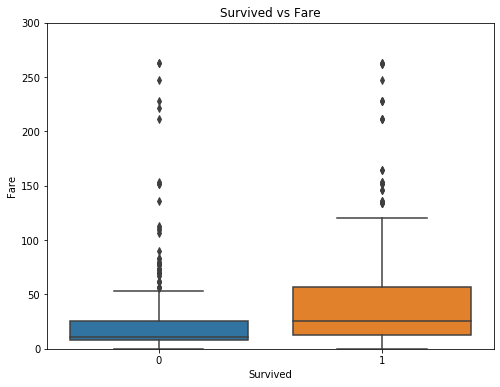

In [20]:
fig, ax=plt.subplots(1,figsize=(8,6))
sns.boxplot(x='Survived',y='Fare', data=train_data)
ax.set_ylim(0,300)
plt.title("Survived vs Fare")
plt.show()

Reality is that there are not that many features, so it is fairly straightforward to include most of them. Let's take a look at which ones have missing values.

In [21]:
print(train_data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Age, Cabin, and Embarked have missing values. So we will impute the values. Also Cabin and Embarked are categorical variables using string values, so we will enconde these into numerics so that they can be used by the RandomForrestClasifier.

In [36]:
train_data = pd.read_csv("data/titanic/train.csv")
train_data.head()

test_data = pd.read_csv("data/titanic/test.csv")
test_data.head()

med=np.nanmedian(train_data['Age'])
train_data['Age']=train_data['Age'].fillna(med)
test_data['Age']=test_data['Age'].fillna(med)
train_data['Cabin']=train_data['Cabin'].fillna("C")
test_data['Cabin']=test_data['Cabin'].fillna("C")
train_data['Embarked']=train_data['Embarked'].fillna("S")
test_data['Fare']=test_data['Fare'].fillna(test_data.Fare.mean())

l=LabelEncoder()
train_data['Sex']=l.fit_transform(train_data['Sex'])
test_data['Sex']=l.fit_transform(test_data['Sex'])

l1=LabelEncoder()
train_data['Embarked']=l1.fit_transform(train_data['Embarked'])
test_data['Embarked']=l1.fit_transform(test_data['Embarked'])

l2=LabelEncoder()
train_data['Cabin']=l2.fit_transform(train_data['Cabin'])
test_data['Cabin']=l2.fit_transform(test_data['Cabin'])


In [40]:
features = ["Pclass", "Sex", "SibSp", "Parch", "Fare", "Age","Cabin", "Embarked"]

X = train_data[features]
X_test = test_data[features]
print(len(X))
print((len(X_test)))
X.head()

891
418


,Pclass,Sex,SibSp,Parch,Fare,Age,Cabin,Embarked
0,3,1,1,0,7.2500,22.0,48,2
1,1,0,1,0,71.2833,38.0,82,0
2,3,0,0,0,7.9250,26.0,48,2
3,1,0,1,0,53.1000,35.0,56,2
4,3,1,0,0,8.0500,35.0,48,2


In [41]:
param_grid = { 
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
model=RandomForestClassifier(random_state=42)
grid_model = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
grid_model.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

We used similar GridSearchCV code to find the optimal hyperparameters which yielded a better accurracy score. 

In [42]:
print(grid_model.best_params_)
print(grid_model.best_score_)

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'n_estimators': 500}
0.8417508417508418


When the prediction were created and submites to Kaggle for scoring it yield an improve accuracy score of 0.7799 resuling of a placement in the top 24% (instead of the top 56%).



# Conclusion
Starting with the easiest features to use: the ones that did not require any transformations. This gave us a smaller set of features to use and less accurate predictions. Trying to find a hyperparameters to further improved the accuracy did not work on it's own. Adding some more predictors as well as searching for optimal hyperparameters improved the accuracy score. This makes us conlude that a more complex model doesn't always yield better results. The largest improvement came from using more and better features. The modeling indciated that if you were female and from a higher socioeconomic class, you had a much better chance of surviving the Titanic.